In [1]:
DATASET_PATH = "output_frames.csv"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [2]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

2025-03-17 18:02:18.117165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742230938.139970   26581 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742230938.146456   26581 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 18:02:18.168157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/fridh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. 

In [3]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

Compute capability: (7, 5)
Turn on mixed_float16


In [4]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [6]:

if (not os.path.exists(DATASET_PATH)):
    print("Error: Dataset not found.")
    sys.exit()

In [7]:
df = pd.read_csv(DATASET_PATH, header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [8]:
dataset = dataset.reshape(dataset.shape[0], 25, 16)
# Transpose each data point.
dataset = np.array([x.T for x in dataset])
input_shape = dataset[0].shape

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {input_shape}")

Dataset shape: (583554, 16, 25)
Labels shape: (583554,)
Input shape: (16, 25)


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [9]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


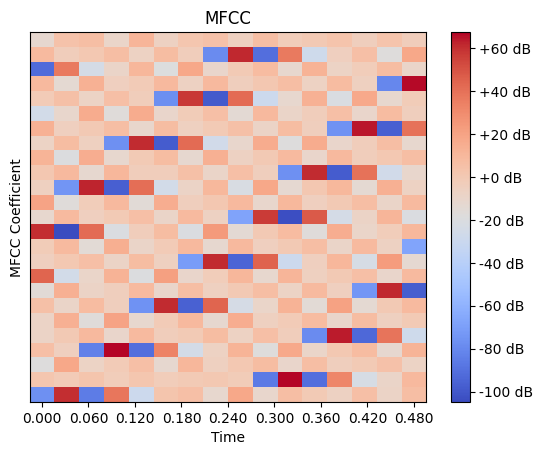

In [10]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [11]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (80% train, 20% test).
x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)

# Further split the training set into training and validation sets (80% train, 20% validation).
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 373474
Validation set length: 93369
Testing set length: 116711


In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [13]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bus' 'Car' 'Motorcycle' 'Truck']


In [14]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [15]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr_on_plateau],
    )
    # Print history
    if doPrintHistory: printHistory(history)

In [17]:
print(input_shape)

(16, 25)


In [18]:
print((input_shape[0], 1))

(16, 1)


# Construct Sequantial Model

...

In [19]:
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, InputLayer, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2

sequential_model = Sequential([

    InputLayer(shape=input_shape),  # 25 frames, 16 channels

    # First Convolutional Block (Lightweight Depthwise Separable Conv)
    SeparableConv1D(filters=64, kernel_size=5, activation="relu", padding='same'),
    BatchNormalization(),
    SeparableConv1D(filters=64, kernel_size=5, activation="relu", padding='same'),
    BatchNormalization(),

    # Second Convolutional Block
    SeparableConv1D(filters=128, kernel_size=5, activation="relu", padding='same'),
    BatchNormalization(),
    SeparableConv1D(filters=128, kernel_size=5, activation="relu", padding='same'),
    BatchNormalization(),

    # Feature Pooling (Combining Max & Average Pooling)
    GlobalAveragePooling1D(),

    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Dropout slightly reduced for stability

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set)), activation="softmax")
])


I0000 00:00:1742230966.381647   26581 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1742230966.381932   26581 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2633 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [20]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()

In [21]:
compileModel(sequential_model, 0.005)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv1d                │ (None, 16, 64)         │         1,789 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_1              │ (None, 16, 64)         │         4,480 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_2              │ (None, 16, 128)        │         8,640 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_3              │ (None, 16, 128)        │        17,152 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,178 (164.76 KB)

 Trainable params: 41,410 (161.76 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/32


I0000 00:00:1742230985.280255   26683 service.cc:148] XLA service 0x7f7b10019ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742230985.280299   26683 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-03-17 18:03:05.386676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742230985.930230   26683 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-17 18:03:06.936790: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[64,1,16,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,1,16,128]{3,2,1,0}, f16[128,1,1,128]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"acti

  30/5836 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - categorical_accuracy: 0.2485 - loss: 1.7492  

I0000 00:00:1742230990.823578   26683 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5827/5836 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.3764 - loss: 1.2865

2025-03-17 18:03:40.588366: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[34,1,16,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[34,1,16,128]{3,2,1,0}, f16[128,1,1,128]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-17 18:03:40.654542: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv (f16[34,1,16,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[34,1,16,128]{3,2,1,0}, f16[64,1,1,128]{3,2,1,0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"cudnn_co

5836/5836 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - categorical_accuracy: 0.3764 - loss: 1.2864 - val_categorical_accuracy: 0.4045 - val_loss: 1.3346 - learning_rate: 0.0050
Epoch 2/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - categorical_accuracy: 0.4321 - loss: 1.1517 - val_categorical_accuracy: 0.4248 - val_loss: 1.2788 - learning_rate: 0.0050
Epoch 3/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - categorical_accuracy: 0.4519 - loss: 1.1156 - val_categorical_accuracy: 0.4491 - val_loss: 1.2412 - learning_rate: 0.0050
Epoch 4/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - categorical_accuracy: 0.4609 - loss: 1.0998 - val_categorical_accuracy: 0.4771 - val_loss: 1.1765 - learning_rate: 0.0050
Epoch 5/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - categorical_accuracy: 0.4698 - loss: 1.0835 - val_categorical_accuracy: 0.4809 - val_loss: 1.1862 - learning_rate: 0.0050
Epoch 6/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - categorical_accuracy: 0.4762 - loss: 1.0692 - val_categoric

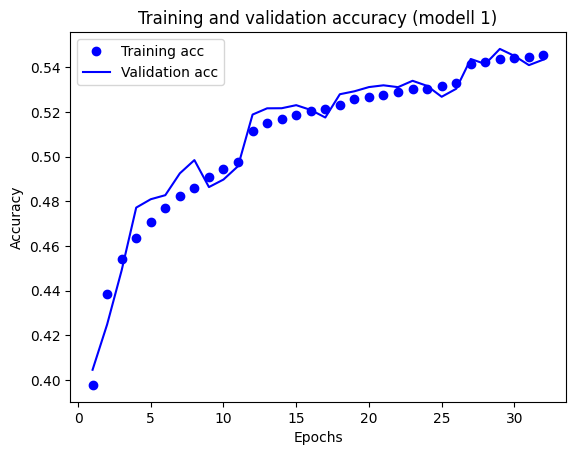

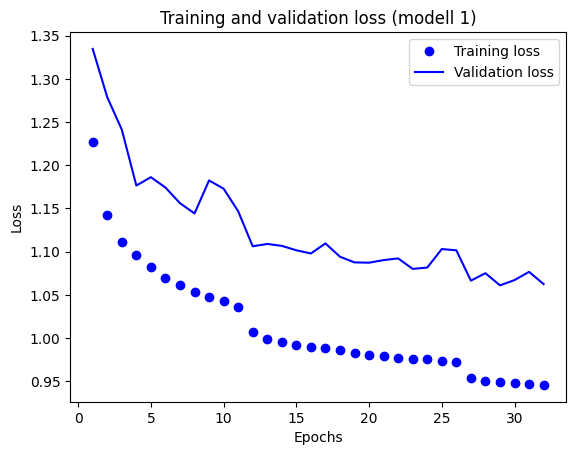

In [23]:
fitModel(sequential_model, x_train, y_train, x_val, y_val, 32, True, dist_class_weight, 1, 64)

In [24]:
# Test the model.
test_loss, test_accuracy = sequential_model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

3648/3648 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - categorical_accuracy: 0.5447 - loss: 1.0626
Test loss: 1.0615965127944946
Test accuracy: 0.5424081683158875


In [25]:
fitModel(sequential_model, x_train, y_train, x_val, y_val, 32, True, dist_class_weight, 1, 64)

Epoch 1/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - categorical_accuracy: 0.5488 - loss: 0.9393 - val_categorical_accuracy: 0.5488 - val_loss: 1.0566 - learning_rate: 6.2500e-04
Epoch 2/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - categorical_accuracy: 0.5493 - loss: 0.9385 - val_categorical_accuracy: 0.5471 - val_loss: 1.0618 - learning_rate: 6.2500e-04
Epoch 3/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - categorical_accuracy: 0.5494 - loss: 0.9384 - val_categorical_accuracy: 0.5492 - val_loss: 1.0529 - learning_rate: 6.2500e-04
Epoch 4/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - categorical_accuracy: 0.5511 - loss: 0.9350 - val_categorical_accuracy: 0.5473 - val_loss: 1.0606 - learning_rate: 6.2500e-04
Epoch 5/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - categorical_accuracy: 0.5503 - loss: 0.9351 - val_categorical_accuracy: 0.5497 - val_loss: 1.0521 - learning_rate: 6.2500e-04
Epoch 6/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - categorical_accuracy: 0.5512

KeyboardInterrupt: 